In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import argparse, cv2, logging, pdb
import matplotlib.pyplot as plt, numpy as np
import focus_stacking.registration.ecc as ecc
import focus_stacking.utils.images as im_utils
import focus_stacking.utils.data_loader as data_loader
from focus_stacking.utils.pyramids import StackPyramid, Pyramid, WaveletPyramid, LaplacianPyramid
import focus_stacking.utils.pyramids
import focus_stacking.energy.energy as energies
import focus_stacking.fusion.fusion as fusion
import pywt

align_max_iters = 50
align_eps = 1e-3
DATA_ROOT = '/n/fs/3d-indoor/macro_data/focus_stacks'

logger = logging.getLogger(__name__)


In [2]:
aux_out_dir = '/n/fs/3d-indoor/tmp_outdir/aux/'
registered_images = data_loader.load_images_from_dir(aux_out_dir, match='reg_*.jpg')

In [12]:
# basic merging based on local variance (contrast)

ksize = 63
transform = lambda x : x
transformed_images = [transform(im) for im in registered_images]
energy_list = []
for image in transformed_images:
    energy = energies.local_variance(image,ksize=ksize)
    energy_list.append(energy)

# fused_im = fusion.fuse_max(energy_list, registered_images)
# cv2.imwrite('/n/fs/3d-indoor/macro_data/focus_stacks/snail/000/f4.0/results/simple_contrast_k=9.jpg', fused_im)

In [17]:
idx = 6
normalized = (energy_list[idx] - energy_list[idx].min())/energy_list[idx].max()
plt.imsave(f'e{idx}.jpg', normalized)

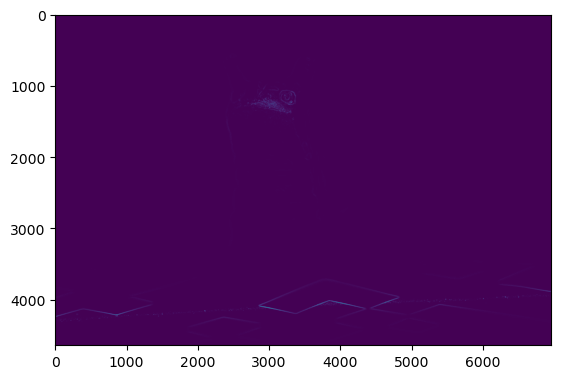

In [6]:
plt.imshow(energy_list[0])

In [25]:
ksize = 63
low_pass_kernel = cv2.getGaussianKernel(ksize, sigma=-1)
transform = lambda im : im_utils.laplacian(im_utils.bgr_to_grayscale(im), ksize)[0]
transformed_images = [transform(im) for im in registered_images]
# basic merging based on local variance (contrast)
energy_list = []
for image in transformed_images:
    energy = image**2
    energy_list.append(energy)

# fusion
fused_im = fusion.fuse_max(energy_list, registered_images)
cv2.imwrite('/n/fs/3d-indoor/macro_data/focus_stacks/snail/000/f4.0/results/max_lap.jpg', fused_im)

True

In [13]:
ksize = 9
transform = lambda im : im
transformed_images = [transform(im) for im in registered_images]
# basic merging based on local variance (contrast)
energy_list = []
for image in transformed_images:
    energy = energies.local_entropy(image,ksize=ksize)
    energy_list.append(energy)

# fusion
fused_im = fusion.fuse_max(energy_list, registered_images)
cv2.imwrite('/n/fs/3d-indoor/macro_data/focus_stacks/snail/000/f4.0/results/simple_entropy.jpg', fused_im)

/tmp/ipykernel_3973803/3160516394.py:7: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  energy = energies.local_entropy(image,ksize=ksize)


True

In [20]:
ksize = 9
low_pass_kernel = cv2.getGaussianKernel(ksize, sigma=-1)
down_pyramid = StackPyramid(registered_images, levels=5, kernel=low_pass_kernel, pyramid_type='laplacian')

for pyramid in down_pyramid.pyramids:
    pyramid.compute_energy_for_levels(-1, im_key='laplacian', energy_type='entropy', ksize=ksize)
    pyramid.compute_energy_for_levels(-1, im_key='laplacian', energy_type='variance', ksize=ksize)
    for level in range(pyramid.num_levels-1):
        pyramid.compute_energy_for_levels(level, im_key='laplacian', energy_type='region', kernel=low_pass_kernel)

base_ims = [pyramid.levels[-1]['laplacian'] for pyramid in down_pyramid.pyramids]
base_entropy = [pyramid.levels[-1]['entropy'] for pyramid in down_pyramid.pyramids]
base_variance = [pyramid.levels[-1]['variance'] for pyramid in down_pyramid.pyramids]
fused_base = fusion.fuse_multiple_max([base_entropy, base_variance], base_ims)

fused_layers = []
for level in range(down_pyramid.pyramids[0].num_levels-1):
    print(level)
    fuse_layer = fusion.fuse_max([pyramid.levels[level]['region'] for pyramid in down_pyramid.pyramids],
                                [pyramid.levels[level]['laplacian'].astype(np.float32) for pyramid in down_pyramid.pyramids])
    fused_layers.append(fuse_layer)
fused_layers.append(fused_base)

reconstruction_layers = [{'laplacian': fused_layer} for fused_layer in fused_layers]
reconstruction_pyramid = LaplacianPyramid(levels=reconstruction_layers, kernel=low_pass_kernel)
fused_im = reconstruction_pyramid.reconstruct()
cv2.imwrite('/n/fs/3d-indoor/macro_data/focus_stacks/snail/000/f4.0/results/lap_pyr_k=9.jpg', fused_im)

making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
0
1
2
3


True

In [85]:
def fuse_single_color_ch(registered_images, index):
    b_ims = [im[...,index].astype(np.float32)/255. for im in registered_images]
    b_stack = StackPyramid(images=b_ims, levels=5, kernel=None, pyramid_type='wavelet', wvt_name='db16')
    for pyramid in b_stack.pyramids:
        pyramid.compute_energy_for_levels(-1, 'image', 'variance', energy_key='variance', ksize=5, im_color=False)
        for level_id in range(pyramid.num_levels):
            pyramid.compute_energy_for_levels(level_id, 'LH', 'variance', energy_key='LH_variance', ksize=5, im_color=False)
            pyramid.compute_energy_for_levels(level_id, 'HL', 'variance', energy_key='HL_variance', ksize=5, im_color=False)
            pyramid.compute_energy_for_levels(level_id, 'HH', 'variance', energy_key='HH_variance', ksize=5, im_color=False)
    LH_levels = []
    HL_levels = []
    HH_levels = []
    for level_id in range(b_stack.pyramids[0].num_levels):
        LH_layer = fusion.fuse_max([pyramid.levels[level_id]['LH']**2 for pyramid in b_stack.pyramids],
                                    [pyramid.levels[level_id]['LH'].astype(np.float32)[...,np.newaxis] for pyramid in b_stack.pyramids])
        HL_layer = fusion.fuse_max([pyramid.levels[level_id]['HL']**2 for pyramid in b_stack.pyramids],
                                    [pyramid.levels[level_id]['HL'].astype(np.float32)[...,np.newaxis] for pyramid in b_stack.pyramids])
        HH_layer = fusion.fuse_max([pyramid.levels[level_id]['HH']**2 for pyramid in b_stack.pyramids],
                                    [pyramid.levels[level_id]['HH'].astype(np.float32)[...,np.newaxis] for pyramid in b_stack.pyramids])
        LH_levels.append(LH_layer)
        HL_levels.append(HL_layer)
        HH_levels.append(HH_layer)
    fuse_base = fusion.fuse_max([pyramid.levels[-1]['variance'] for pyramid in b_stack.pyramids],
                                    [pyramid.levels[-1]['image'].astype(np.float32)[...,np.newaxis] for pyramid in b_stack.pyramids])
    recon_levels = [{'LH': LH_levels[i][...,0],
      'HL': HL_levels[i][...,0],
      'HH': HH_levels[i][...,0]} for i in range(len(LH_levels))]
    recon_levels.append({'image': fuse_base[...,0]})
    recon_pyramid = WaveletPyramid(levels=recon_levels, wvt_name='db16')
    fused_b = recon_pyramid.reconstruct()
    return fused_b

In [86]:
fused_b = fuse_color(registered_images, 0)
fused_g = fuse_color(registered_images, 1)
fused_r = fuse_color(registered_images, 2)
fused_im = np.clip(np.stack([fused_b, fused_g, fused_r], axis=-1),0,1)
cv2.imwrite('/n/fs/3d-indoor/macro_data/focus_stacks/snail/000/f4.0/results/haar_wavelet_k=5.jpg', (fused_im*255).astype(np.uint8))

making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
(175, 247) (175, 247) (175, 247)
(319, 464) (319, 464) (319, 464)
(607, 897) (607, 897) (607, 897)
(1183, 1763) (1183, 1763) (1183, 1763)
(2335, 3495) (2335, 3495) (2335, 3495)
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
(175, 247) (175, 247) (175, 247)
(319, 464) (319, 464) (319, 464)
(607, 897) (607, 897) (607, 897)
(1183, 1763) (1183, 1763) (1183, 1763)
(2335, 3495) (2335, 3495) (2335, 3495)
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
(175, 247) (175, 247) (175, 247)
(319, 464) (319, 464) (319, 464)
(607, 897) (607, 897) (607, 897)
(1183, 1763) (1183, 1763) (1183, 1763)
(2335, 3495) (2335, 3495) (2335, 3495)


True

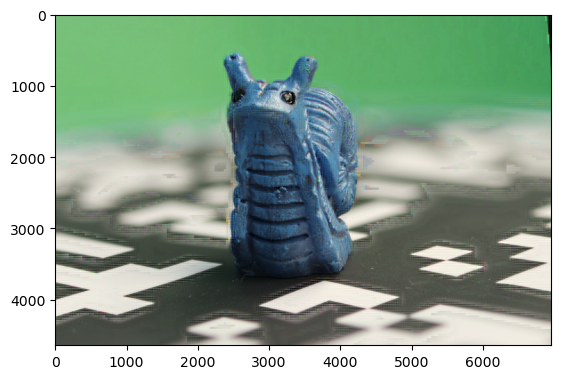

In [80]:
plt.imshow(fused_im)

In [81]:
cv2.imwrite('/n/fs/3d-indoor/macro_data/focus_stacks/snail/000/f4.0/results/haar_wavelet_k=5.jpg', (fused_im*255).astype(np.uint8))

True

In [84]:
b_ims = [im[...,0].astype(np.float32)/255. for im in registered_images]
b_stack = StackPyramid(images=b_ims, levels=5, kernel=None, pyramid_type='wavelet', wvt_name='db16')
for pyramid in b_stack.pyramids:
    pyramid.compute_energy_for_levels(-1, 'image', 'variance', energy_key='variance', ksize=5, im_color=False)
    for level_id in range(pyramid.num_levels):
        pyramid.compute_energy_for_levels(level_id, 'LH', 'variance', energy_key='LH_variance', ksize=5, im_color=False)
        pyramid.compute_energy_for_levels(level_id, 'HL', 'variance', energy_key='HL_variance', ksize=5, im_color=False)
        pyramid.compute_energy_for_levels(level_id, 'HH', 'variance', energy_key='HH_variance', ksize=5, im_color=False)
LH_levels = []
HL_levels = []
HH_levels = []
for level_id in range(b_stack.pyramids[0].num_levels):
    LH_layer = fusion.fuse_max([pyramid.levels[level_id]['LH']**2 for pyramid in b_stack.pyramids],
                                [pyramid.levels[level_id]['LH'].astype(np.float32)[...,np.newaxis] for pyramid in b_stack.pyramids])
    HL_layer = fusion.fuse_max([pyramid.levels[level_id]['HL']**2 for pyramid in b_stack.pyramids],
                                [pyramid.levels[level_id]['HL'].astype(np.float32)[...,np.newaxis] for pyramid in b_stack.pyramids])
    HH_layer = fusion.fuse_max([pyramid.levels[level_id]['HH']**2 for pyramid in b_stack.pyramids],
                                [pyramid.levels[level_id]['HH'].astype(np.float32)[...,np.newaxis] for pyramid in b_stack.pyramids])
    LH_levels.append(LH_layer)
    HL_levels.append(HL_layer)
    HH_levels.append(HH_layer)
fuse_base = fusion.fuse_max([pyramid.levels[-1]['variance'] for pyramid in b_stack.pyramids],
                                [pyramid.levels[-1]['image'].astype(np.float32)[...,np.newaxis] for pyramid in b_stack.pyramids])
recon_levels = [{'LH': LH_levels[i][...,0],
  'HL': HL_levels[i][...,0],
  'HH': HH_levels[i][...,0]} for i in range(len(LH_levels))]
recon_levels.append({'image': fuse_base[...,0]})
recon_pyramid = WaveletPyramid(levels=recon_levels, wvt_name='db16')
fused_b = recon_pyramid.reconstruct()

making pyramid
making pyramid
making pyramid


KeyboardInterrupt: 

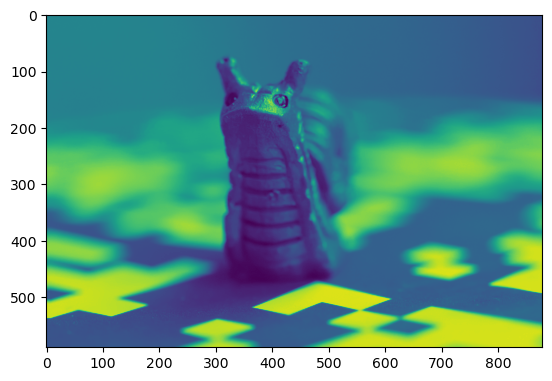

In [45]:
plt.imshow(b_stack.pyramids[0].levels[3]['image'])

In [64]:
np.mean((b_stack.pyramids[3].levels[0]['image'] - b_stack.pyramids[3].reconstruct())**2)

(155, 228) (155, 228) (155, 228)
(300, 445) (300, 445) (300, 445)
(589, 879) (589, 879) (589, 879)
(1168, 1748) (1168, 1748) (1168, 1748)
(2325, 3485) (2325, 3485) (2325, 3485)


2.0303935e-14

(155, 228) (155, 228) (155, 228)
(300, 445) (300, 445) (300, 445)
(589, 879) (589, 879) (589, 879)
(1168, 1748) (1168, 1748) (1168, 1748)
(2325, 3485) (2325, 3485) (2325, 3485)


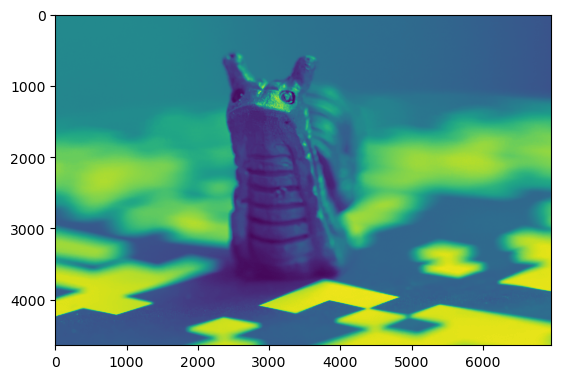

In [61]:
plt.imshow(b_stack.pyramids[0].reconstruct())

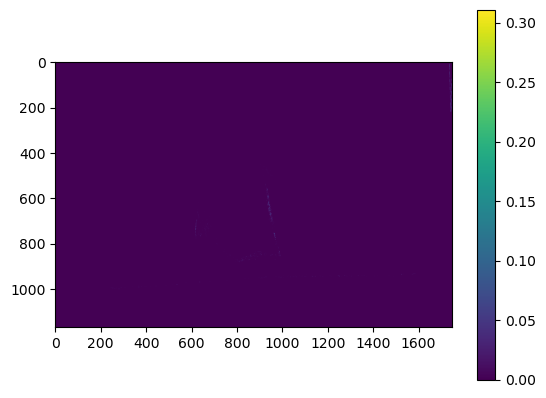

In [65]:
plt.imshow(b_stack.pyramids[3].levels[1]['HL']**2)
plt.colorbar()

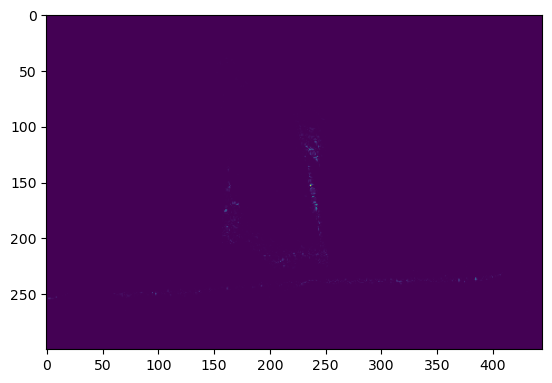

In [58]:
plt.imshow(b_stack.pyramids[3].levels[3]['HH']**2)

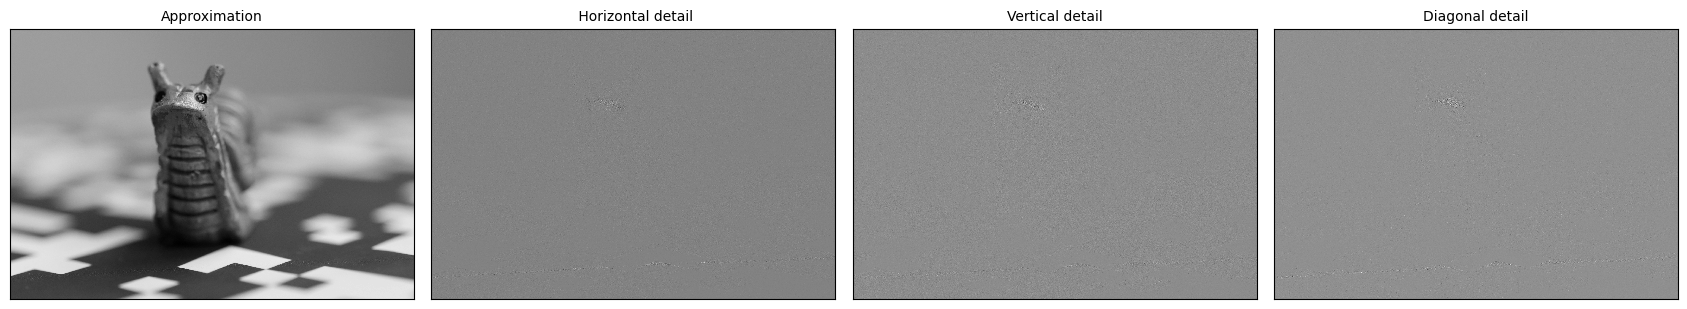

In [82]:
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(im_utils.bgr_to_grayscale(registered_images[0].astype(np.float32)), 'db16')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(17, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [83]:
pywt.Wavelet('db16')

pywt._extensions._pywt.Wavelet(name='db16', filter_bank=([-2.109339630100743e-08, 2.3087840868575457e-07, -7.363656785451205e-07, -1.0435713423116066e-06, 1.1336608661276258e-05, -1.3945668988208893e-05, -6.103596621410936e-05, 0.00017478724522533817, 0.00011424152003872239, -0.0009410217493595676, 0.00040789698084971285, 0.003128023381206269, -0.00364427962149839, -0.006990014563413916, 0.013993768859828731, 0.01029765964095597, -0.03688839769173014, -0.007588974368857738, 0.07592423604427631, -0.006239722752474872, -0.1323883055638104, 0.027340263752716042, 0.2111906939471043, -0.027918208133028276, -0.3270633105279177, -0.08975108940248964, 0.4402902568863569, 0.637356332083789, 0.4303127228460038, 0.16506428348885313, 0.034907714323673344, 0.003189220925347738], [-0.003189220925347738, 0.034907714323673344, -0.16506428348885313, 0.4303127228460038, -0.637356332083789, 0.4402902568863569, 0.08975108940248964, -0.3270633105279177, 0.027918208133028276, 0.2111906939471043, -0.02734026